In [1]:
country  = 'Portugal'

# Introduction

This notebook evaluates several epidemiology models for COVID-19 data.

The primary difference from classical models is that each model includes variable $O$ for _Observed_ cases. Models use the simplest estimation for $O$:

$$\frac{dO}{dt} = k I$$

where $k$ is _reveal efficiency_ coeffitient, showing, how many infected people are identified and positevely tested.

Models have $n$ parameters and $m$ variables in initial vectors. Combined they form $n+m$-dimentional area where we search a solution for IV problem that approximates known cases best. To find the optimal solution we use _Non-linear Least Squares_ method from `scipy.optimize` package (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)).

For every model we present 5 best solutions found. The field `Precision` in the report table is the standard deviation of the solution from data spots.

# The best model

It is expected that the best model for COVID-19 is [SIR with carriers](#sirc)

# TOC
* [Country data](#country)
* [Models with immunity](#r-models)
* * [Basic SIR model](#sir)
* * [Model with carriers](#sirc)
* * [Model with incubation period](#seir)

* [Models without immunity](#s-models)
* * [Basic SIRS model](#sirs)
* * [Model with carriers](#sirsc)
* * [Model with incubation period](#seirs)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from scipy.integrate import odeint
from datetime import datetime

%matplotlib inline

In [3]:
print("Computed on: ", datetime.now().strftime(format='%y-%m-%d %T'))

Computed on:  20-05-08 23:31:45


In [4]:
import corona

# Country data <a name="country"/>

In [5]:
info = corona.CovidModel(country)
print("Country: ", info.country)
print("Population: ", info.population)
print("Number of revealed cases: ", info.data[0][-1])
print("Number of deaths: ", info.data[1][-1])

Country:  Portugal
Population:  10283822.0
Number of revealed cases:  26715
Number of deaths:  1105


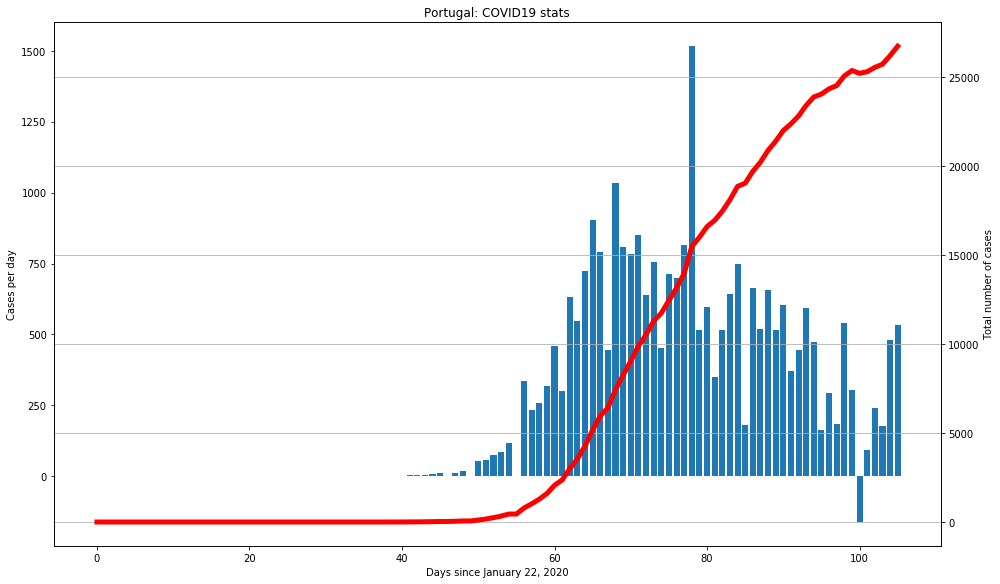

In [6]:
delta = info.data[:,1:] - info.data[:,:-1]
days = np.arange(np.shape(delta)[1])

fig, ax1 = plt.subplots(figsize=(14,8))

ax1.bar(days, delta[0], width=.8)
ax1.set_ylabel('Cases per day')
ax1.set_xlabel("Days since January 22, 2020")

ax2 = ax1.twinx()
ax2.plot(days, info.data[0][1:], '-', color='red', linewidth=5)
ax2.set_ylabel('Total number of cases')
fig.tight_layout()

plt.title(info.country + ": COVID19 stats");
plt.grid()

Red dots show the total number of confirmed cases. Blue bars represent number of confirmed cases daily.

"Day 0" is January 22, when WHO started collecting data from countries.

# Models with immunity <a name="r-models"/>

## SIR - the basic epidemiology model <a name="sir"/>
This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Susceptible*
- **I** is *Infectious*
- **R** is *Recovered* (and *diseased*). The model expects that this pool becomes 100% immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The model utilises three parameters: $\alpha$,$\beta$ and $k$:
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths)
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:<br>
$\frac{dS}{dt} = -\alpha S I$,<br>
$\frac{dI}{dt} = \alpha S I - \beta I$, <br>
$\frac{dR}{dt} = \beta I$,<br>
$\frac{dO}{dt} = k I$.

The initial value vector is ${S_0, I_0, R_0, O_0}$, where $S_0 = 1 - I_0 - R_0$ and $O_0$ is the number of revealed cases at the beginning. The initial values $I_0$ and $R_0$ are guessed during optimization process.

Progress: [####################] 100.0% 523.0707257864973


,alpha,beta,reveal efficiency,Infected initial,Recovered initial,R0,Precision
0,1.44,1.31,0.0199,2600.0,36.1,1.09,523
1,1.44,1.31,0.0199,2600.0,40.9,1.09,523
2,1.44,1.31,0.0199,2600.0,2600.0,1.09,523
3,1.44,1.31,0.0199,2600.0,0.5,1.09,523
4,1.44,1.31,0.0199,2600.0,212.6,1.09,523
5,1.44,1.31,0.0199,2600.0,2.1,1.09,523
6,1.44,1.31,0.0199,2600.0,2594.9,1.09,523
7,1.44,1.31,0.0199,2600.0,226.4,1.09,523
8,1.44,1.31,0.0199,2600.0,2600.0,1.09,523
9,1.44,1.31,0.0199,2600.0,2063.4,1.09,523


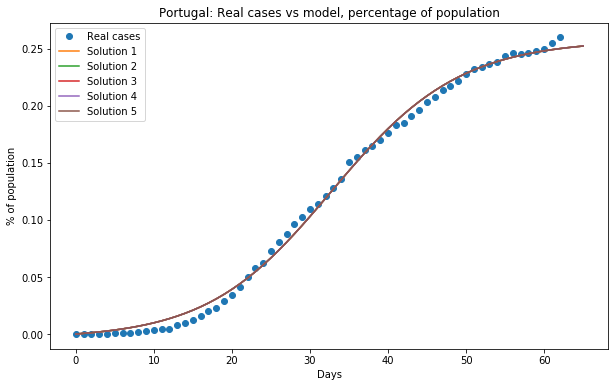

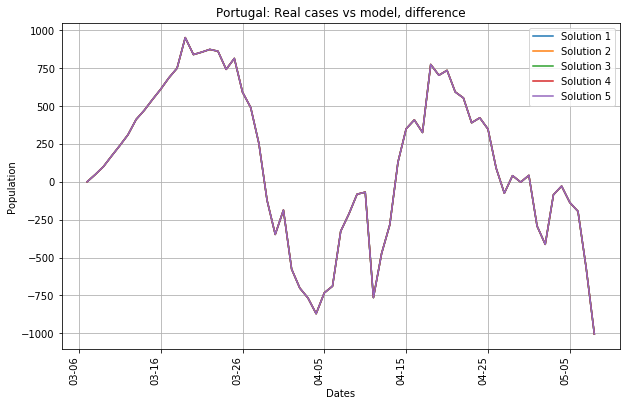

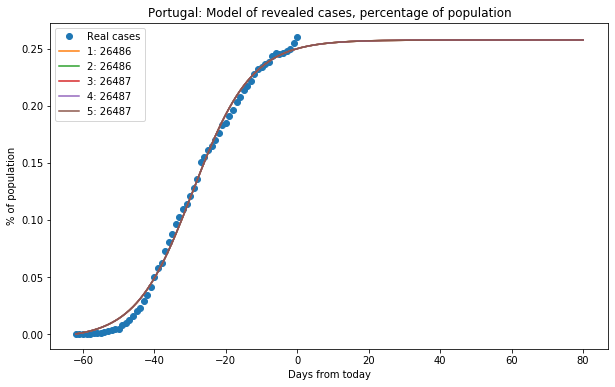

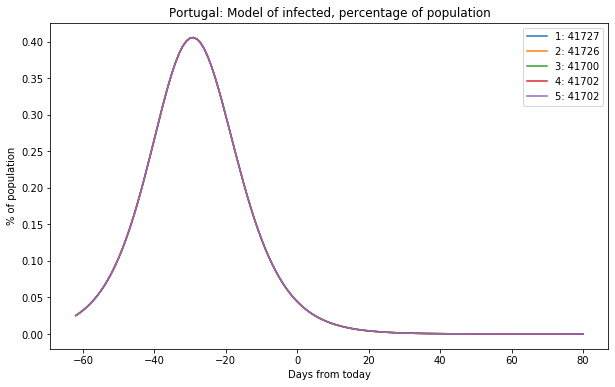

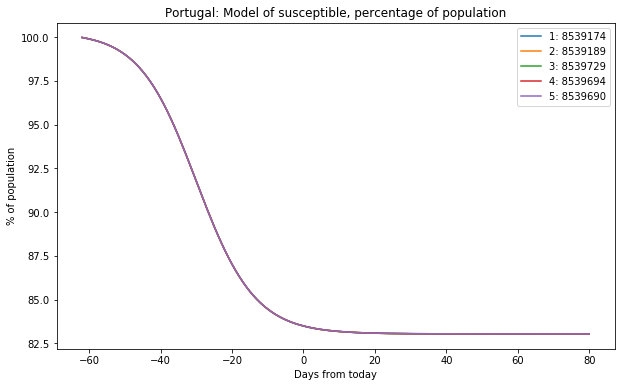

In [7]:
test_sir = corona.CovidModel(country, model='sir_o_r0')

test_sir.run(500, figsize=(10, 6))

## Part of the population are symptom-less infectious carriers <a name="sirc"/>
**SIRC-O** - a SIR model with carriers and with explicit confirmed cases. Recovered species posess immunity.

This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **I** is *Infectious*, i.e. with syptoms of the disease.
- **C** is *Carrier*, i.e. infectious, but without symptoms or actual illness.
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is having people carry the virus and infect others without actually being ill.

The model utilises the following parameters: 
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $c_s$ models efficiency of infection transmission by carriers compared to infectious.
- $i_r$ is the ratio of infectious, who recovered (became immune), and $1 - i_r$ become carriers.
- $c_r$ represents the speed of recovery of carriers.
- $c_i$ represents the speed of conversion of carriers to infected.
- $k$ is the reveal factor, how many infectious people and carriers are confirmed as positive.

The differential equations:
$\frac{dS}{dt} = -\alpha S I - c_s \alpha S C$,<br>
$\frac{dI}{dt} = \alpha S I + c_s \alpha S C - \beta I$ + c_i C, <br>
$\frac{dR}{dt} = \beta i_r I$ + c_r C,<br>
$\frac{dC}{dt} = \beta (1 - i_r) I - (c_r + c_i) C$,<br>
$\frac{dO}{dt} = k (I + C)$.

The initial value vector is ${S_0, I_0, R_0, C_0, O_0}$, where $S_0 = 1 - I_0 - R_0 - C_0$, and $O_0$ is the number of revealed cases at the beginning. The initial values $I_0$, $R_0$ and $C_0$ are guessed during optimization process.

Progress: [####################] 100.0% 195.8429010991471


,alpha,beta,carrier efficiency,infectious to recovered,carrier recovery,carrier to infectious,reveal efficiency,Initial infected,Initial carrier,Initial recovered,R0,Precision
0,3.46,3.82,0.141,0.851,0.0866,0.000236,0.00209,1619.2,1959.3,514.6,0.906,196
1,2.79,2.95,0.0886,0.785,0.0414,0.0577,0.00149,2098.9,2385.3,643.6,0.948,196
2,2.26,2.46,0.131,0.756,0.0388,0.0538,0.00105,2599.6,2183.3,1667.1,0.916,197
3,2.38,2.86,0.294,0.861,0.00498,0.0802,0.00151,13.6,364.9,2373.3,0.833,197
4,1.98,2.19,0.176,0.738,0.075,0.00117,0.000917,2594.0,1964.5,2599.9,0.903,197
5,2.68,2.72,0.0284,0.359,0.0912,6.65e-07,0.000669,2370.6,2478.2,2203.9,0.985,198
6,2.97,3.63,0.565,0.941,0.0764,1.4e-06,0.00343,38.7,1616.1,778.7,0.818,198
7,1.82,2.28,0.512,0.871,0.0681,2.5e-07,0.00141,14.4,2057.1,2592.4,0.798,199
8,2.45,2.56,0.27,0.913,0.0858,0.000423,0.00323,13.6,847.9,1355.0,0.955,199
9,1.76,3.58,0.531,0.647,0.278,0.544,0.0104,1794.2,2154.9,2599.1,0.491,490


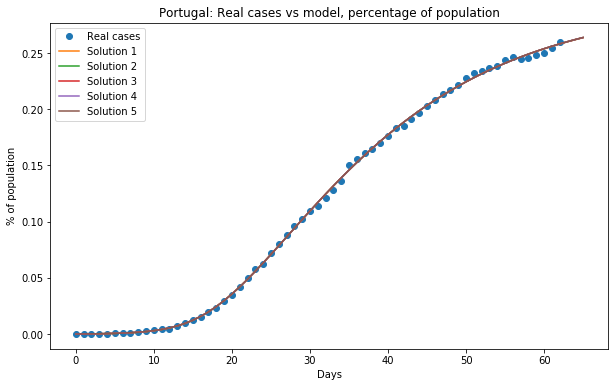

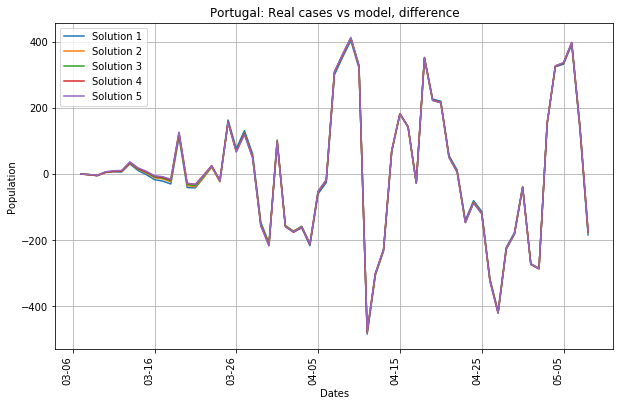

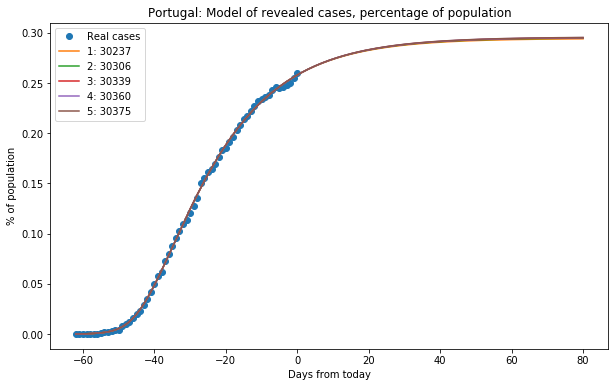

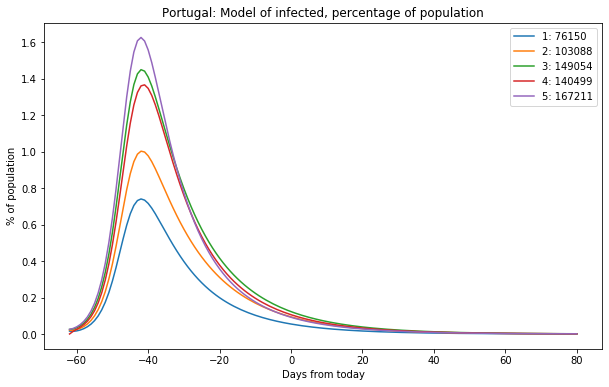

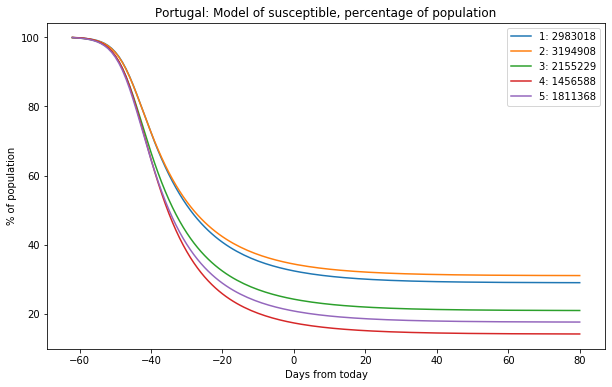

In [8]:
test_sirc = corona.CovidModel(country, model='sir_co')
test_sirc.run(300)

## Model with exposed (incubation period) <a name="seir"/>
    
**SEIR-O** is SIR model with incubation period.

This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **E** is *Exposed*, i.e. people who are infected, but not yet infectious.
- **I** is *Infectious*
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is conversion of some or recovered back into succeptible.

The model utilises the following parameters: 
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $e_i$ represents the speed of becoming infectious,
- $e_i$ represents the speed of becoming immune without becoming infectious,
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:<br>
$\frac{dS}{dt} = -\alpha S I$,<br>
$\frac{dE}{dt} = \alpha S I - e_i E - e_r E$, <br>
$\frac{dI}{dt} = e_i E - \beta I$, <br>
$\frac{dR}{dt} = \beta I + e_r E$,<br>
$\frac{dO}{dt} = k I$.

The initial value vector is ${S_0, E_0, I_0, R_0, O_0}$, where $S_0 = 1 - E_0 - I_0 - R_0$ and $O_0$ is the number of revealed cases at the beginning. The initial values $E_0$, $I_0$ and $R_0$ are guessed during optimization process.


Progress: [####################] 100.0% 269.806195058135


,alpha,beta,exposed to infected,exposed to recovered,reveal efficiency,Infected initial,Exposed initial,Recovered initial,R0,Precision
0,2.66,0.0352,0.567,2.98,0.000732,2600.0,2599.8,2288.2,75.5,270
1,2.79,0.765,1.24,2.54,0.0188,2528.7,2585.2,1118.3,3.65,520
2,2.68,0.763,1.3,2.51,0.018,2599.3,2598.5,2101.3,3.52,520
3,3.02,0.735,0.947,2.25,0.019,2596.9,2570.4,610.3,4.11,520
4,3.86,0.739,0.673,2.21,0.024,2377.3,1721.3,586.6,5.22,521
5,3.16,0.805,1.15,2.65,0.0221,2083.1,2599.5,716.2,3.93,521
6,2.09,0.854,2.25,2.44,0.0158,2600.0,2600.0,391.8,2.45,522
7,2.2,0.913,2.46,2.65,0.0181,2525.2,1940.8,244.1,2.41,522
8,3.03,0.905,1.49,2.78,0.024,2081.3,1761.1,1192.5,3.35,523
9,2.1,0.977,2.9,2.52,0.0185,2304.5,2089.7,1566.9,2.15,523


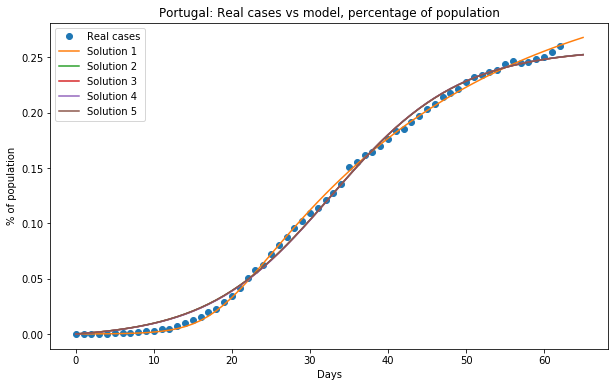

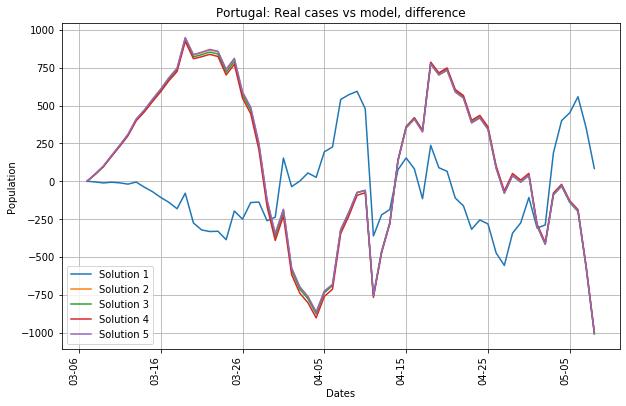

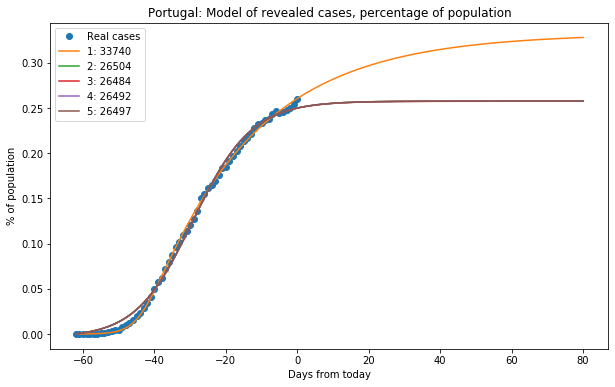

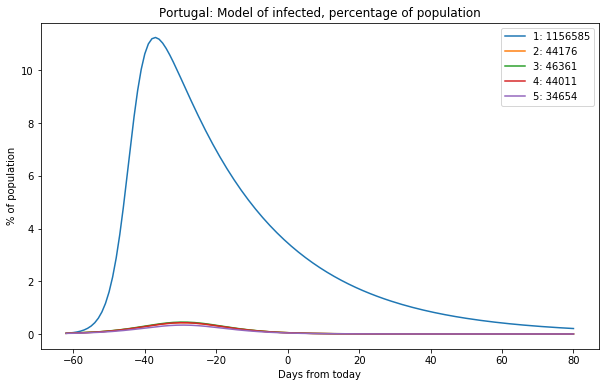

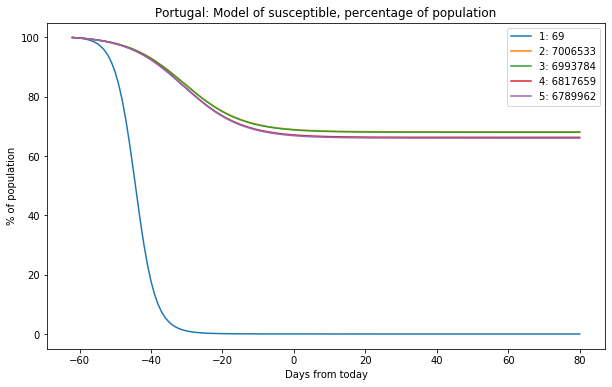

In [9]:
test_seir = corona.CovidModel(country, model='seir_o')

test_seir.run(300)

# Models without immunity <a name="s-models"></a>


## Some of recovered become susceptible again <a name="sirs"/>

**SIRS-O** is SIR model without antigen and with explicit confirmed cases

This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **I** is *Infectious*
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is conversion of some or recovered back into succeptible.

The model utilises the following parameters: 
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $r_s$ is the ratio of recovered people who are susceptible again,
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:<br>
$\frac{dS}{dt} = -\alpha S I + r_s R$,<br>
$\frac{dI}{dt} = \alpha S I - \beta I$, <br>
$\frac{dR}{dt} = \beta I - r_s R$,<br>
$\frac{dO}{dt} = k I$.

The initial value vector is ${S_0, I_0, R_0, O_0}$, where $S_0 = 1 - I_0 - R_0$ and $O_0$ is the number of revealed cases at the beginning. The initial values $I_0$ and $R_0$ are guessed during optimization process.


Progress: [####################] 100.0% 321.7091473954647


,alpha,beta,recovered to susceptible,reveal efficiency,Infected initial,Recovered initial,R0,Precision
0,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
1,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
2,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
3,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
4,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
5,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
6,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
7,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
8,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322
9,1.59,1.41,0.00919,0.0594,2600.0,0.0,1.13,322


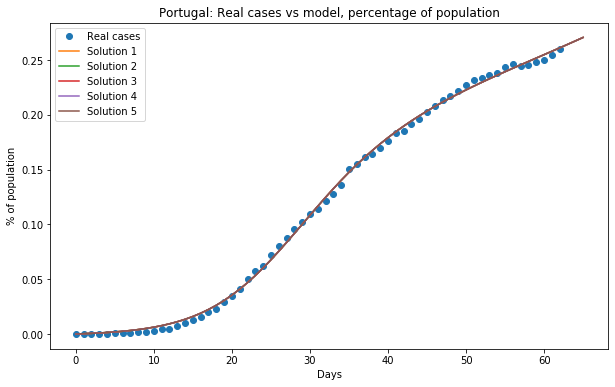

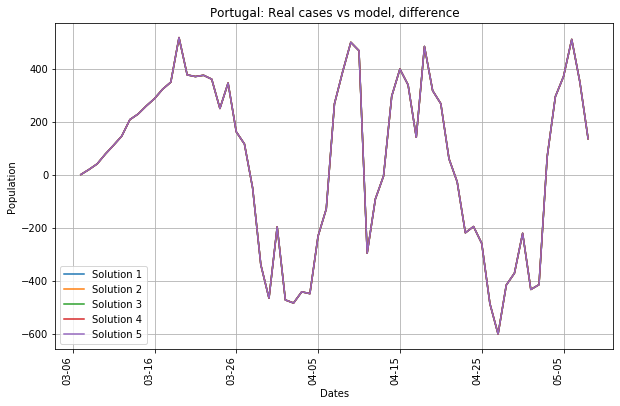

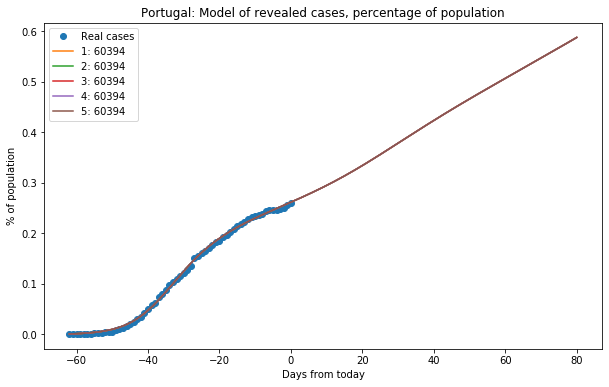

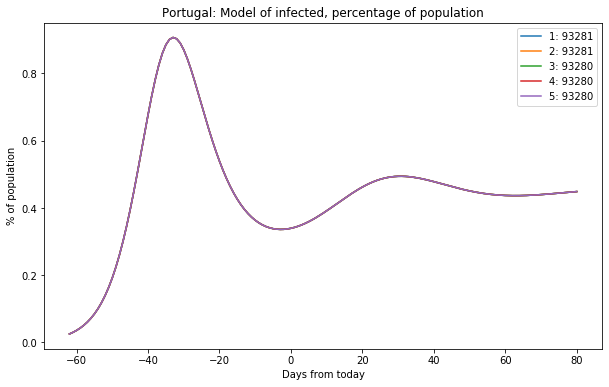

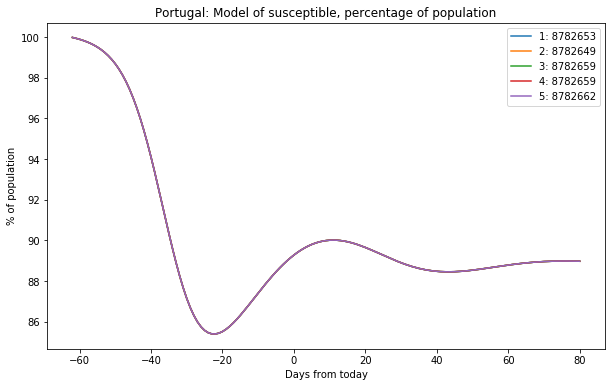

In [10]:
test_sirs = corona.CovidModel(country, model='sir_so_r0')
test_sirs.run(300)

## Part of the population are symptom-less infectious carriers, and recovered loose the immunity<a name="sirsc"/>

**SIRSC-O** - a SIRS model with carriers and with explicit confirmed cases. Recovered species turn back into susceptible.

This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **I** is *Infectious*, i.e. with syptoms of the disease.
- **C** is *Carrier*, i.e. infectious, but without symptoms or actual illness.
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is having people carry the virus and infect others without actually being ill.

The model utilises the following parameters: 
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $c_s$ models efficiency of infection transmission by carriers compared to infectious.
- $i_r$ is the ratio of infectious, who recovered (became immune), and $1 - i_r$ become carriers.
- $c_r$ represents the speed of recovery of carriers.
- $c_i$ represents the speed of conversion of carriers to infected.
- $r_s$  is the ratio of recovered people who are susceptible again. 
- $k$ is the reveal factor, how many infectious people and carriers are confirmed as positive.

The differential equations:
$\frac{dS}{dt} = -\alpha S I - c_s \alpha S C$ + r_s R,<br>
$\frac{dI}{dt} = \alpha S I + c_s \alpha S C - \beta I$ + c_i C, <br>
$\frac{dR}{dt} = \beta i_r I + c_r C - r_s R$,<br>
$\frac{dC}{dt} = \beta (1 - i_r) I - (c_r + c_i) C$,<br>
$\frac{dO}{dt} = k (I + C)$.

The initial value vector is ${S_0, I_0, R_0, C_0, O_0}$, where $S_0 = 1 - I_0 - R_0 - C_0$, and $O_0$ is the number of revealed cases at the beginning. The initial values $I_0$, $R_0$ and $C_0$ are guessed during optimization process.

Progress: [####################] 100.0% 297.87057619727153


,alpha,beta,carrier efficiency,infectious to recovered,carrier recovery,carrier to infectious,recovered to susceptible,reveal efficiency,Initial infected,Initial carrier,Initial recovered,R0,Precision
0,1.33,1.17,0.752,0.999,0.0203,0.0391,0.0489,0.00712,29.8,1767.5,902.8,1.14,298
1,1.32,1.75,0.433,0.724,9.39e-06,1.17,0.0539,0.00388,2599.6,0.0,2599.6,0.751,307
2,1.08,1.06,0.907,0.887,0.507,0.156,0.0546,0.00383,2597.9,0.0,2599.1,1.02,311
3,2.1,3.21,0.607,0.734,0.412,0.741,0.0564,0.00903,1881.5,442.0,733.3,0.654,312
4,1.09,0.916,0.566,0.996,0.266,1.67,0.0566,0.00424,2600.0,0.0,2600.0,1.19,316
5,1.11,0.953,0.775,0.98,0.649,2.11,0.0567,0.00441,2600.0,0.0,2600.0,1.17,316
6,1.14,1.19,0.973,0.817,0.7,2.87,0.0567,0.00461,2483.1,48.9,2455.6,0.957,317
7,1.81,2.74,0.47,0.629,0.434,1.87,0.0581,0.00807,1697.8,31.1,1172.1,0.658,318
8,1.32,1.36,0.237,0.769,1.05,2.03,0.0576,0.00554,2376.8,48.9,2416.4,0.965,318
9,1.39,1.49,0.236,0.699,1.2,1.48,0.0579,0.00584,2357.3,269.0,2333.8,0.929,318


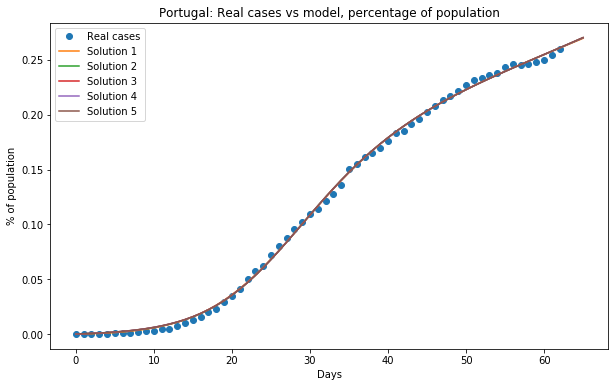

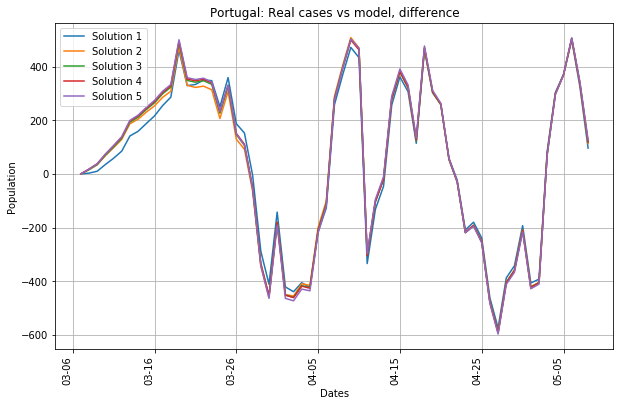

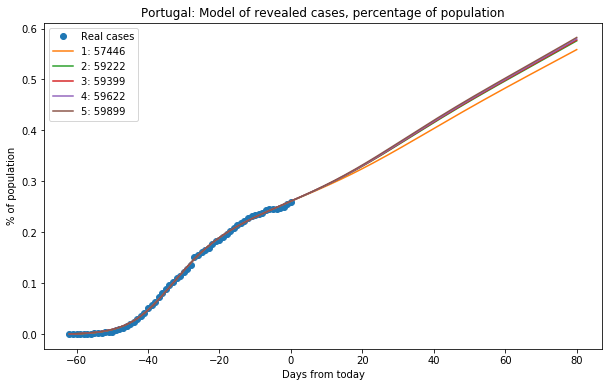

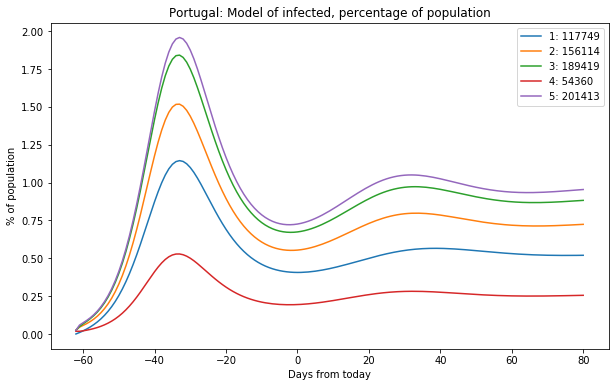

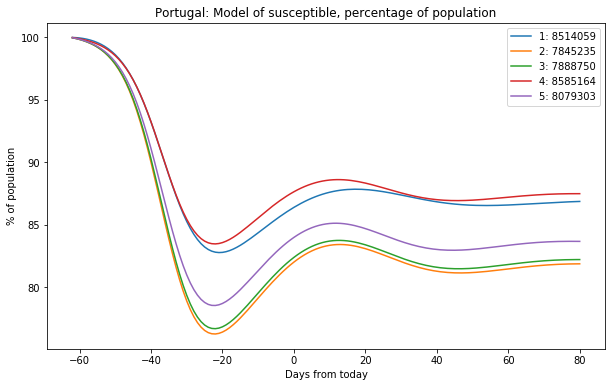

In [11]:
test_sir_sco = corona.CovidModel(country, model='sir_sco')
test_sir_sco.run(300)


## Experimental model with carriers and no immunity
The model is almost the same as the previous one. The only difference is in revealing efficiency for infectious and carriers. It expects that infectious and carriers are revealed at different pace.

- $k_i$ is the reveal factor, how many infectious people are confirmed as positive.
- $k_c$ is the reveal factor, how many carriers are confirmed as positive.

The differential equations:<br>
$\frac{dS}{dt} = -\alpha S I - c_s \alpha S C$ + r_s R,<br>
$\frac{dI}{dt} = \alpha S I + c_s \alpha S C - \beta I$ + c_i C, <br>
$\frac{dR}{dt} = \beta i_r I + c_r C - r_s R$,<br>
$\frac{dC}{dt} = \beta (1 - i_r) I - (c_r + c_i) C$,<br>
$\frac{dO}{dt} = k_i I + k_c C$.

The initial value vector is ${S_0, I_0, R_0, C_0, O_0}$, where $S_0 = 1 - I_0 - R_0 - C_0$, and $O_0$ is the number of revealed cases at the beginning. The initial values $I_0$, $R_0$ and $C_0$ are guessed during optimization process.

Progress: [####################] 100.0% 201.60070767661568


,alpha,beta,carrier efficiency,infectious to recovered,carrier recovery,carrier to infectious,recovered to susceptible,Infectious reveal efficiency,Carrier reveal efficiency,Initial infected,Initial carrier,Initial recovered,R0,Precision
0,1.01,0.941,0.987,0.921,8.4e-06,0.0726,5.67e-07,0.000358,0.00256,2600.0,33.9,2599.9,1.08,202
1,2.07,2.45,0.226,0.795,0.166,0.595,0.0532,0.0118,1.11e-07,29.7,64.8,2598.2,0.845,301
2,2.4,3.04,0.878,0.884,0.431,0.524,0.0568,0.0173,0.00684,184.9,98.5,797.5,0.789,311
3,1.5,1.87,0.138,0.555,0.99,1.63,0.0574,0.00737,1.15e-06,2072.1,10.7,2597.3,0.804,316
4,1.44,1.48,0.0977,0.689,1.07,0.864,0.0576,0.00712,5.78e-06,2403.3,0.2,2598.9,0.972,317
5,1.36,1.94,0.547,0.499,1.15,1.36,0.0559,0.00773,7.12e-06,2060.9,933.1,2557.0,0.699,318
6,2.16,2.85,0.299,0.516,1.16,0.526,0.0589,0.0177,0.00011,338.6,37.1,2598.6,0.758,318
7,1.27,1.27,0.587,0.752,1.81,0.846,0.0578,0.00626,6.49e-07,2545.6,0.2,2599.8,1,318
8,1.88,3.05,0.622,0.559,0.98,1.29,0.0588,0.00365,0.0194,1469.6,402.1,1100.1,0.615,320
9,1.5,1.42,0.67,0.929,1.05,2.12,0.0586,0.00834,2e-05,745.8,1302.4,2384.7,1.06,320


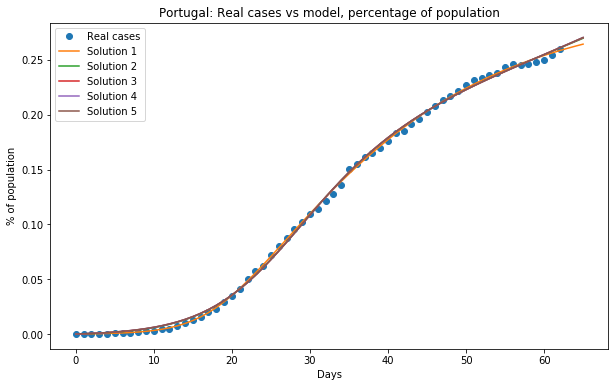

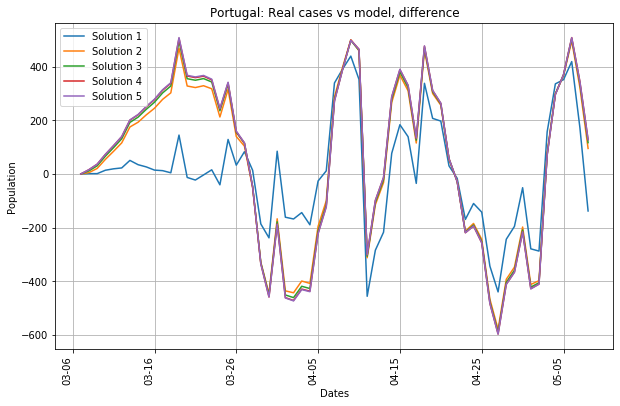

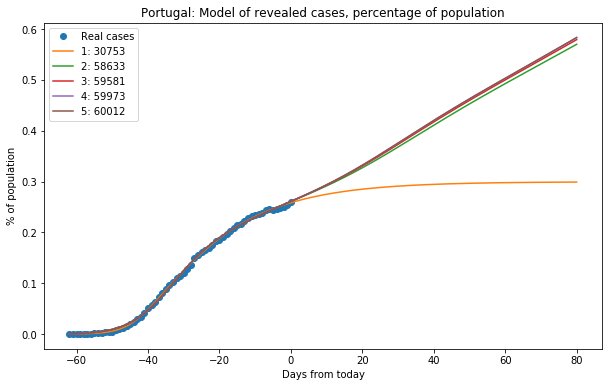

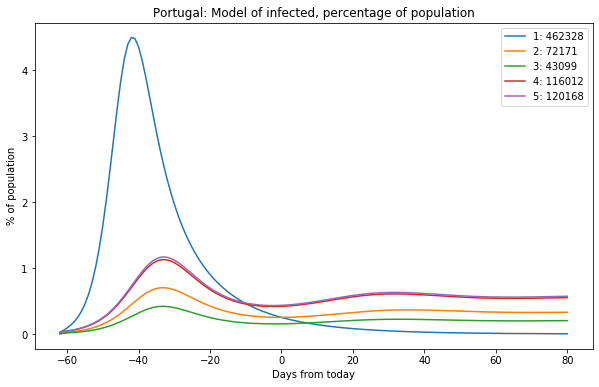

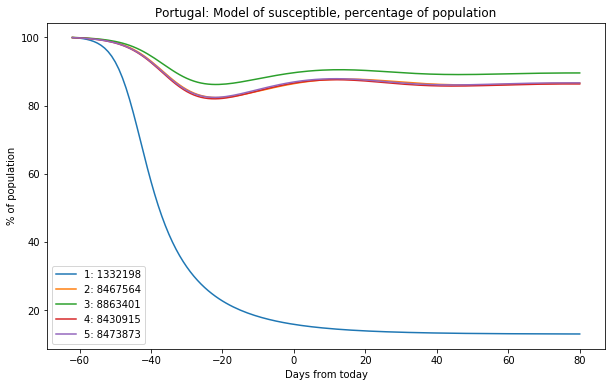

In [12]:
test_sir_sco_kc = corona.CovidModel(country, model='sir_sco_kc')
test_sir_sco_kc.run(300)

## Model with incubation period and no immunity (SEIRS) <a name="seirs"/>

**SEIRS-O** is SIR model with incubation period and no immunity (recovered turn back into susceptible).

This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **E** is *Exposed*, i.e. people who are infected, but not yet infectious.
- **I** is *Infectious*
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is conversion of some or recovered back into succeptible.

The model utilises the following parameters: 
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $e_i$ represents the speed of becoming infectious,
- $e_i$ represents the speed of becoming immune without becoming infectious,
- $r_s$ is the ratio of recovered people who are susceptible again,
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:<br>
$\frac{dS}{dt} = -\alpha S I + r_s R$,<br>
$\frac{dE}{dt} = \alpha S I - e_i E - e_r E$, <br>
$\frac{dI}{dt} = e_i E - \beta I$, <br>
$\frac{dR}{dt} = \beta I + e_r E - r_s R$,<br>
$\frac{dO}{dt} = k I$.

The initial value vector is ${S_0, E_0, I_0, R_0, O_0}$, where $S_0 = 1 - E_0 - I_0 - R_0$ and $O_0$ is the number of revealed cases at the beginning. The initial values $E_0$, $I_0$ and $R_0$ are guessed during optimization process.


Progress: [####################] 100.0% 314.37326164931926


,alpha,beta,exposed to infected,exposed to recovered,recovered to susceptible,reveal efficiency,Infected initial,Exposed initial,Recovered initial,R0,Precision
0,4.22,0.631,0.651,2.55,0.0527,0.00934,2532.1,2593.5,112.9,6.69,314
1,4.47,0.837,0.492,1.5,0.0552,0.0108,2599.3,2598.3,0.3,5.33,321
2,2.83,1.02,1.47,1.84,0.057,0.00906,2478.3,2598.6,43.3,2.79,322
3,3.14,1.07,1.6,2.25,0.0577,0.0107,1994.9,2312.4,619.6,2.93,323
4,2.51,1.11,2.2,1.93,0.0576,0.00901,2576.8,1841.4,74.3,2.27,323
5,2.64,1.06,1.58,1.61,0.0575,0.00861,2584.4,2597.9,45.9,2.49,323
6,4.16,1.29,1.28,2.19,0.0596,0.0156,1911.1,740.5,1516.0,3.23,325
7,2.58,1.35,3,1.91,0.0561,0.0117,1784.6,1865.7,696.1,1.91,326
8,3.68,1.42,1.43,1.7,0.0602,0.0142,1636.3,2027.6,1675.5,2.6,326
9,3.02,1.41,1.3,1.01,0.0586,0.0108,2434.6,2523.3,46.9,2.15,326


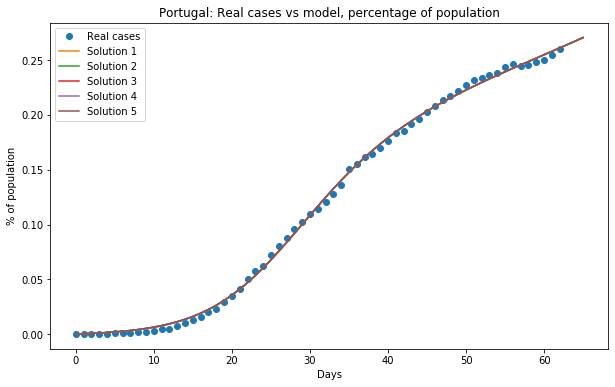

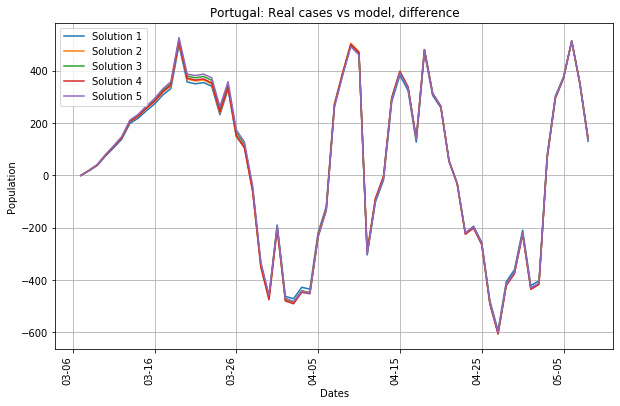

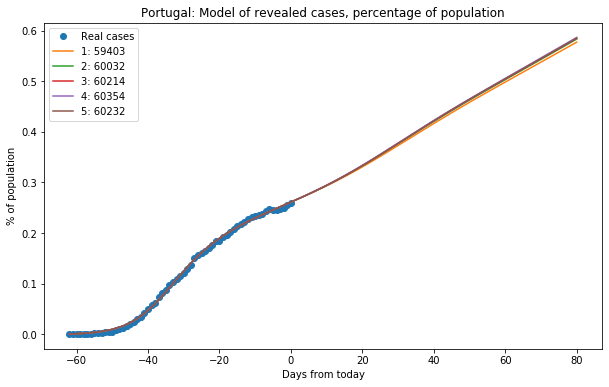

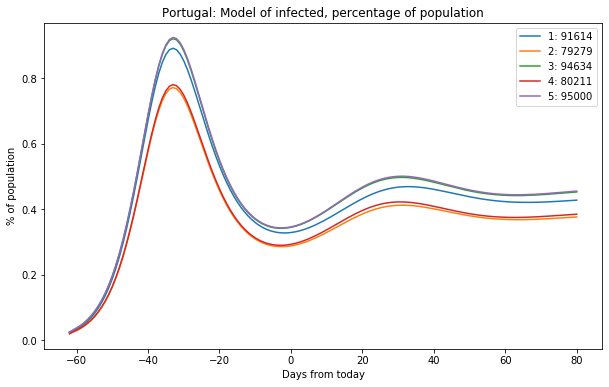

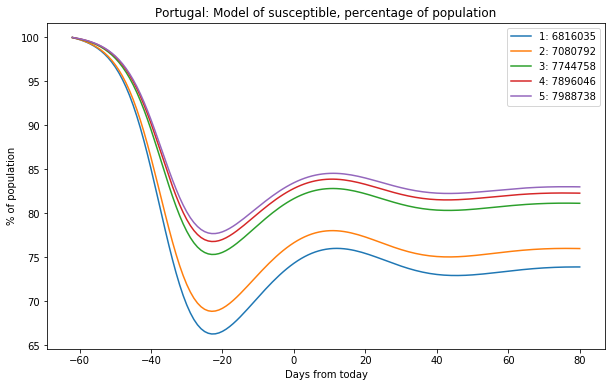

In [13]:
test_seir_so = corona.CovidModel(country, model='seir_so')
test_seir_so.run(300)